In [1]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import convolve
from sklearn import linear_model, datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.base import clone

import pandas as pd
%matplotlib inline


# Restricted Boltzmann Machine features for digit classification


For greyscale image data where pixel values can be interpreted as degrees of
blackness on a white background, like handwritten digit recognition, the
Bernoulli Restricted Boltzmann machine model `BernoulliRBM` can perform effective non-linear
feature extraction.

In order to learn good latent representations from a small dataset, we
artificially generate more labeled data by perturbing the training data with
linear shifts of 1 pixel in each direction.

This example shows how to build a classification pipeline with a BernoulliRBM
feature extractor and a :class:`LogisticRegression` classifier. The hyperparameters
of the entire model (learning rate, hidden layer size, regularization)
were optimized by grid search, but the search is not reproduced here because
of runtime constraints.

Logistic regression on raw pixel values is presented for comparison. The
example shows that the features extracted by the BernoulliRBM help improve the
classification accuracy.



# David's understanding of what this code is doing:

## 1. Load 64x64 pixel images of faces
From website: "There are ten different images of each of 40 distinct subjects... The image is quantized to 256 grey levels and stored as unsigned 8-bit integers... The “target” for this database is an integer from 0 to 39 indicating the identity of the person pictured"

## 2. Train RBM so we can classify using Logistic Regression
### How RBM trains:
RBM is unsupervised. It starts with 2 layers (input and hidden) with nodes of random weights. It then tunes weights by iteratively moving forwards and backwards across these two layers, trying to reconstruct each other.

While there aren't outcome variables to test against, what we're doing here is *extracting simplified features of the images* that will serve as effective features to use when training a classifier (in this case Logistic Regression). As an article puts it: *Because those weights already approximate the features of the data, they are well positioned to learn better when, in a second step, you try to classify images with the deep-belief network in a subsequent supervised learning stage.*

### RBM hyper-parameters
Before running the training, we can optimise (at least) the following hyper-parameters:
- learnign rate (how fast the model adjusts its weights)
- number of iterations (sweeps over dataset during training???)
- number of components, ie units in the hidden layer (**which will be translated to features**)

## 3. Evaluation
Here, we compare Logistic Regression trained on **the RBM features VS the raw pixels**. We look at metrics like Recall and F score.

### Visualizing RBM features
We can look at the features extracted by RBM by plotting the components.

What exactly do the components represent? __I THINK: the pixels best at linking an image to its label, and vice versa**

## Prep data

### Note that original dataset had 1700\*5 images. We only will have 400\*5.

In [35]:
digits = datasets.load_digits()
len(digits.data)

1797

In [2]:
faces = datasets.fetch_olivetti_faces()

### Sample image

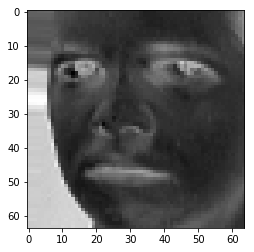

In [26]:
_img = np.asarray(faces.data, 'float32')[5].reshape((64, 64))
plt.imshow(_img, cmap=plt.cm.gray_r, interpolation='nearest')

In [36]:
def nudge_dataset(X, Y):
    """
    This produces a dataset 5 times bigger than the original one,
    by moving the 8x8 images in X around by 1px to left, right, down, up
    """
    direction_vectors = [
        [[0, 1, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [1, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 1],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 1, 0]]
    ]

    def shift(x, w):
        return convolve(x.reshape((64, 64)), mode='constant', weights=w).ravel()

    X = np.concatenate([X] +
                       [np.apply_along_axis(shift, 1, X, vector)
                        for vector in direction_vectors])
    Y = np.concatenate([Y for _ in range(5)], axis=0)
    return X, Y

## Prep data

In [37]:
X = np.asarray(faces.data, 'float32')
Y = faces.target
X, Y = nudge_dataset(X, faces.target)

X = (X - np.min(X, 0)) / (np.max(X, 0) + 0.0001)  # 0-1 scaling

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=0)

# Models we will use
logistic = linear_model.LogisticRegression(solver='lbfgs', max_iter=10000,
                                           multi_class='multinomial')
rbm = BernoulliRBM(random_state=0, verbose=True)

rbm_features_classifier = Pipeline(steps=[('rbm', rbm), ('logistic', logistic)])

# Train

In [38]:
# #############################################################################
# Training

# Hyper-parameters. These were set by cross-validation,
# using a GridSearchCV. Here we are not performing cross-validation to
# save time.
rbm.learning_rate = 0.06
rbm.n_iter = 20
# More components tend to give better prediction performance, but larger
# fitting time
rbm.n_components = 100
logistic.C = 6000

# Training RBM-Logistic Pipeline
rbm_features_classifier.fit(X_train, Y_train)

# Training the Logistic regression classifier directly on the pixel
raw_pixel_classifier = clone(logistic)
raw_pixel_classifier.C = 100.
raw_pixel_classifier.fit(X_train, Y_train)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -2740.17, time = 1.39s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -2742.30, time = 1.42s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -2716.96, time = 1.17s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -2711.04, time = 1.20s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -2704.87, time = 1.19s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -2699.70, time = 1.55s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -2698.56, time = 1.17s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -2718.42, time = 1.20s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -2719.68, time = 1.15s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -2697.19, time = 1.39s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -2702.57, time = 1.30s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -2721.30, time = 1.29s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -2706.84, time = 1.37s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -2688.85, time = 1.43s
[

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

## Evaluate, print extracted features

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Logistic regression using RBM features:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.00      0.00      0.00        12
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        14
           4       0.06      0.10      0.08        10
           5       0.00      0.00      0.00        12
           6       0.00      0.00      0.00         9
           7       0.75      0.30      0.43        10
           8       0.00      0.00      0.00         9
           9       0.42      0.45      0.43        11
          10       0.13      0.67      0.22         9
          11       0.27      0.58      0.37        12
          12       0.00      0.00      0.00         8
          13       0.00      0.00      0.00        11
          14       0.00      0.00      0.00        12
          15       0.00      0.00      0.00        12
          16       0.10      0.20      0.

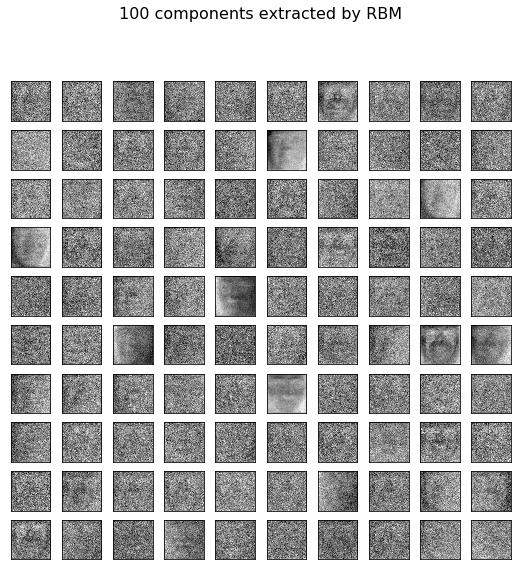

In [39]:
# #############################################################################
# Evaluation

Y_pred = rbm_features_classifier.predict(X_test)
print("Logistic regression using RBM features:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))

Y_pred = raw_pixel_classifier.predict(X_test)
print("Logistic regression using raw pixel features:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))

# #############################################################################
# Plotting

plt.figure(figsize=(8.4, 8))
for i, comp in enumerate(rbm.components_):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((64, 64)), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('100 components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()

# SO.. WHY IS LINEAR BETTER in this case? (when RBM helped for the digit dataset)
Is it simply because the digit dataset was 5x bigger than the faces dataset? I know NN need *a lot of data* to perform well. Relatedly, does the fact facial images are 64x64 rather than 8x8 impact preformance?

Or because they tuned the hyper-parameters just right for the image dataset?